# Bayesian Statistical Inference
## PyIU Advanced Python Workshop

Last modified: 4/12/2025

Author: Brandon Radzom

## Bayesian Statistics and Bayes' Theorem

Bayesian statistics is an approach to data analysis and parameter estimation based on Bayes' theorem. More generally, in Bayesian statistics, a probability represents the degree of belief in an event, which may be informed based on prior knowledge about the event, such as the results of previous experiments. We use prior probability distributions (prior knowledge) and data (evidence) to compute an expected posterior probability distribution, and often iterate on this process. Written intuitively, we compute:

Posterior = (Likelihood $\times$ Prior) / Evidence

Selecting a good models/distributions for the data is paramount for the success of Bayesian inference. One should keep in mind, however, that models often only approximate reality, and may not take into account certain factors influencing the data. Of importance in this notebook example, we can assign Bayesian probabilities to model parameters, which can be treated like random variables. We then use Bayes' theorem to iteratively update probabilities using more and more evidence. Critically, **Bayesian inference allows us to quantify the uncertainty** associated with our expected/inferenced value.

Bayesian statistics/inference is quite complex, and we refer students to various external resources to familiarize themselves with its fundamentals:
- Bayesian modeling in Python: https://bayesiancomputationbook.com/welcome.html
- Bayesian statistics Crash Course on YouTube: https://www.youtube.com/watch?v=9TDjifpGj-k

In this notebook, we will infer the **intrinsic distribution of 3D stellar obliquities**, i.e., the angle between stars' rotational axes and their planets' orbital axes, which is represented as $\psi$. We will use real data of 2D sky-projected spin-orbit angles $\lambda$, compiled in Table 2 of [Radzom et al. (2024)](https://iopscience.iop.org/article/10.3847/1538-3881/ad61d8), to do so. Usually, in order to calculate the 3D obliquity, one must obtain the 2D obliquity as well as the planetary orbital inclination $i$ and stellar inclination $i_*$ with respect to the line of site, as shown in the equation below:
$$\cos(\psi)=\cos(i_*)\cos(i)+\sin(i_*)\sin(i)\cos(\lambda)$$
However, it is often easier to determine the planetary inclination than the stellar inclination. Therefore, if we lack the stellar inclination data to understand the true distribution of 3D obliquities, we can use Bayesian methods to infer it from known $\lambda$ and $i$ values. Here's a schematic diagram to help you visualize the problem:

![obliquity](https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-981-10-8453-9_2/MediaObjects/454895_1_En_2_Fig1_HTML.gif)


This demo is inspired by the Bayesian inference techniques developed by Prof. Jiayin Dong (Flatiron Institute - Center for Computational Astrophysics, University of Illinois - Urbana-Champaign), which are posted on [GitHub](https://github.com/jiayindong/obliquity/blob/main/obliquity_distribution_demos.ipynb).

Let's begin by importing the necessary packages, including the Bayesian statistics package `pymc`. More straightforward demos of using Bayesian inference with `pymc` are available online, including this [Introductory Demo](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview) and various [example notebooks](https://www.pymc.io/projects/examples/en/latest/gallery.html).

In [1]:
### import all the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
import pymc as pm
import arviz as az
import pytensor.tensor as at
import pytensor

In [2]:
!pip install corner # force install of corner package

In [3]:
import corner # import corner

Now we read our $\lambda$ and $i$ data from $\texttt{Radzom2024_table2.csv}$. Make sure to upload this file to your local directory or your Google Colab session so you can easily access it!

In [5]:
subSat_data = pd.read_csv('Radzom2024_table2.csv')


We also perform some pre-processing operations to shuffle some errors around.

In [6]:
### try inference of psi with lambda, iorb data.

### pre-processing of uncertainties
obs_iorb_deg = subSat_data['inc']
obs_iorb_uerr_deg = subSat_data['inc_uerr']
# replace 0s in upper errors with 0.1 deg, since they should be 0 since they're all for i=90
i_of_0 = np.where((obs_iorb_uerr_deg == 0))[0]
for i in i_of_0:
    obs_iorb_uerr_deg[i] = 0.1 # 0.1 deg error
obs_iorb_lerr_deg = subSat_data['inc_lerr']
obs_iorb_combinederr_deg = np.append(obs_iorb_uerr_deg, obs_iorb_lerr_deg)
# make error array randomly draw errors from both uerr and lerr
rand_inds = []
for err in range(len(obs_iorb_deg)):
    i = np.random.randint(0,len(obs_iorb_combinederr_deg),1)[0]
    while i in rand_inds:
        i = np.random.randint(0,len(obs_iorb_combinederr_deg),1)[0]
    rand_inds.append(i)
rand_inds = np.asarray(rand_inds)
err_iorb_deg = np.abs(obs_iorb_combinederr_deg[rand_inds])

obs_lam_deg = np.abs(subSat_data['lam'])
obs_lam_uerr_deg = subSat_data['lam_uerr']
obs_lam_lerr_deg = subSat_data['lam_lerr']
obs_lam_combinederr_deg = np.append(obs_lam_uerr_deg, obs_lam_lerr_deg)
# make error array randomly draw errors from both uerr and lerr
rand_inds = []
for err in range(len(obs_lam_deg)):
    i = np.random.randint(0,len(obs_lam_combinederr_deg),1)[0]
    while i in rand_inds:
        i = np.random.randint(0,len(obs_lam_combinederr_deg),1)[0]
    rand_inds.append(i)
rand_inds = np.asarray(rand_inds)
err_lam_deg = np.abs(obs_lam_combinederr_deg[rand_inds])

<ipython-input-6-0a23a45accaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_iorb_uerr_deg[i] = 0.1 # 0.1 deg error
<ipython-input-6-0a23a45accaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_iorb_uerr_deg[i] = 0.1 # 0.1 deg error
<ipython-input-6-0a23a45accaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_iorb_uerr_deg[i] = 0.1 # 0.1 deg error
<ipython-input-6-0a23a45accaa>:9: SettingWithCopyWarning: 
A value is 

Let's visualize the data we will be working with. We can plot the distributions of $i$ and $\lambda$ below, and notice that our observed 2D obliquity distribution is double-peaked. Will this peak also show up in the inferred 3D distribution of $\psi$?

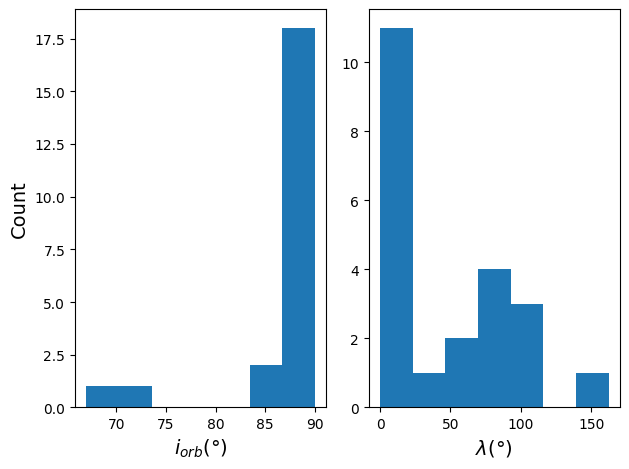

In [7]:
### plot histograms of input parameters iorb and lambda
plt.subplot(1, 2, 1)
plt.hist(obs_iorb_deg, bins=7)
plt.xlabel(r'$i_{orb} (\degree)$', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.subplot(1, 2, 2)
plt.hist(obs_lam_deg, bins=7)
plt.xlabel(r'$\lambda (\degree)$', fontsize=14)
plt.tight_layout()

In [8]:
### convert the iorbs, lams to radians
obs_iorb = np.pi*obs_iorb_deg/180
obs_lam = np.pi*obs_lam_deg/180

err_iorb = np.pi*err_iorb_deg/180
err_lam = np.pi*err_lam_deg/180

Now we are ready to define and sample our Bayesian model with `pymc`. We adopt a 2-component model since we assume that the $\psi$ distribution comprises: 1) an aligned population with low obliquity and 2) a misaligned population with higher obliquity. This is a valid assumption as we can see there is a double peak in the 2D obliquities!

In [9]:
# we infer 6 parameters to describe the psi distribution
# params: {w0, w1, mu0, k0, mu1, k1}
# w0 = fraction of misaligned population; w1 = fraction of aligned population
# mu0 = mean psi of misaligned population; k0 = concentration (should be low)
# mu1 = mean of aligned population; k1 = concentration (high)

### predictors are: lambda, iorb
nsample = 22
with pm.Model() as model_istar:
    # change to single component
    ncomps = 2

    # define hyperprior
    # Dirichlet is a generalization of the beta distribution to multiple variables
    w = pm.Dirichlet('w', np.ones(ncomps))
    # define prior on mu depending on the number of components
    if ncomps > 1:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps,
                       transform=pm.distributions.transforms.Ordered(),
                       initval=np.array([0.5,0.9])) # mean value initialized at 0.5 for misaligned, 0.9 for aligned
    else:
        μ = pm.Uniform('mu', lower=0., upper=1., shape=ncomps)
    # set the log(kappa) prior to Gaussian with mu = 3. No sigma specified?
    logκ = pm.Normal('logkappa', 3.0, shape=ncomps)
    # set of deterministic variables
    # set concentration kappa
    κ = pm.Deterministic('kappa', pm.math.exp(logκ))
    # alpha and beta of beta distribution
    a = pm.Deterministic('a', μ*κ)
    b = pm.Deterministic('b', (1-μ)*κ)

    # mixture cosψ distribution
    u = pm.Mixture('u', w=w, comp_dists=pm.Beta.dist(a,b, shape=(ncomps,)), shape=nsample)

    cosψ = pm.Deterministic('cosψ', 2*u-1)
    sinψ = pm.Deterministic('sinψ', at.sqrt(1-cosψ**2))

    # uniform θ prior
    θ = pm.Uniform('θ', lower=0, upper=np.pi, shape=nsample)
    # deterministic variables
    sinθ = pm.Deterministic('sinθ', at.sin(θ))
    cosθ = pm.Deterministic('cosθ', at.cos(θ))

    # uniform cosiorb prior.
    cosiorb = pm.Uniform('cosiorb', lower=0., upper=0.4, shape=nsample)
    # deterministic variable
    iorb = pm.Deterministic('iorb', at.arccos(cosiorb))

    # find λ in terms of ψ, θ, and iorb
    λ = pm.Deterministic('λ', at.arctan2(sinψ*sinθ, cosψ*at.sin(iorb)-sinψ*cosθ*at.cos(iorb)))

    # logl for iorb; observed parameters obs_iorb and err_iorb
    logl_iorb = pm.Normal('logl_iorb', mu=iorb, sigma=err_iorb, observed=obs_iorb)

    # logl for λ; observed parameters obs_lam and err_lam
    logl_λ = pm.Normal('logl_λ', mu=λ, sigma=err_lam, observed=obs_lam)
    # can also change "tune" and "iterations" parameters
    idata = pm.sample(draws=1000, nuts={'target_accept':0.99, 'max_treedepth':13}, random_seed=123) # 'step_scale':0.01

# hyperprior for w0 or omega0, which is fraction of misaligned population,

# w1 or omega1 is fraction of aligned population

Output()

ERROR:pymc.stats.convergence:There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The sampling process generally takes awhile, but the computation time depends on many factors such as the number of draws, tuning draws, the target_accept threshold, the number of chains, etc. Now that it's done running, we can analyze the results, beginning with the summary statistics for each parameter:

In [10]:
### print summary of parameters
### HDI = Highest-Density Interval = shortest interval that contains a given prob. density
### r_hat = convergence statistic
az.summary(idata, var_names=['w','mu','logkappa'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.436,0.138,0.137,0.666,0.007,0.008,482.0,382.0,1.00
w[1],0.564,0.138,0.334,0.863,0.007,0.008,482.0,382.0,1.00
mu[0],0.496,0.080,0.345,0.637,0.005,0.007,352.0,188.0,1.01
mu[1],0.964,0.046,0.868,1.000,0.003,0.004,250.0,251.0,1.01
logkappa[0],2.601,0.786,1.238,4.185,0.037,0.038,486.0,266.0,1.00
logkappa[1],2.510,1.196,0.280,4.639,0.060,0.033,404.0,432.0,1.00


In [11]:
### visual representation of the above data
### curves are computed using a Kernal Density Estimator (KDE) = smooth histogram
### the black horizontal lines correspond to the HDI
### WARNING: THIS PLOT TAKES A MINUTE, so only uncomment if you really need to see distributions for each parameter...
# az.plot_posterior(idata)
# plt.tight_layout()

We can also visually plot the sampled or posterior distributions for each parameter:

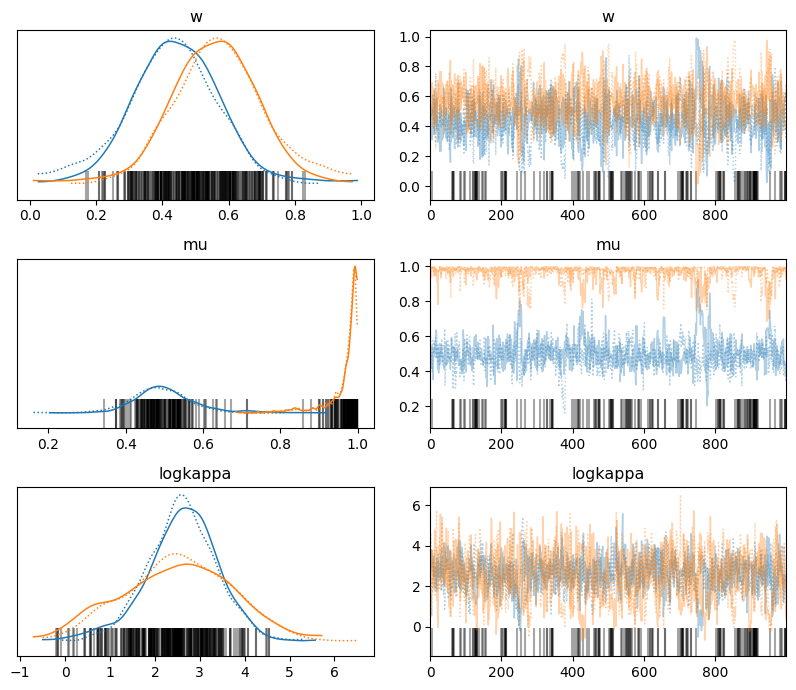

In [12]:
### left panels correspond to the distribution of the sampled values over all iterations of the MCMC
### right panels correspond to the sampled values at each iteration of the MCMC

# recall params: {w0, w1, mu0, k0, mu1, k1}
# w0 = fraction of misaligned population; w1 = fraction of aligned population
# mu0 = mean psi of misaligned population; k0 = concentration (should be low)
# mu1 = mean of aligned population; k1 = concentration (high)
az.plot_trace(idata, var_names=['w','mu','logkappa'], figsize=(8,7))
plt.tight_layout()
# plt.savefig(f'./plots/inferred_params_subSat{ncomps}comp.png')

<Axes: >

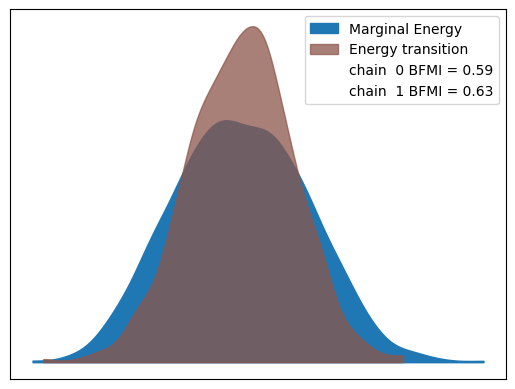

In [13]:
### check to see if posterior distribution was sampled fully
### marginal energy distribution should match the ste energy distribution
az.plot_energy(idata)

Corner plots are a standard way to view the posteriors and the highest density intervals/quantiles for each:

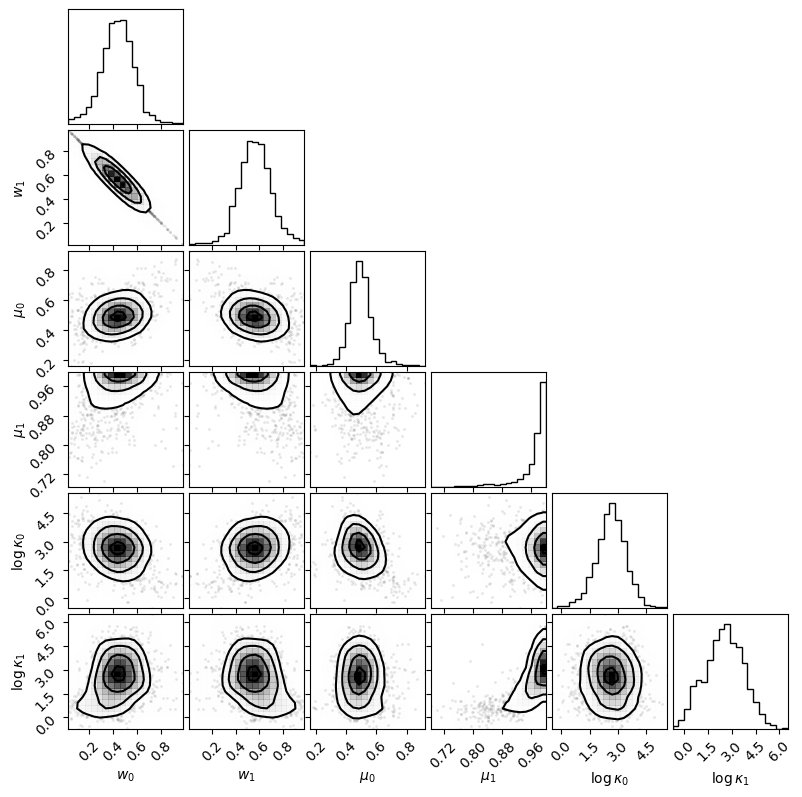

In [14]:

fig = corner.corner(idata, var_names=['w','mu','logkappa'], smooth=True, labelpad=0.05,
                    labels=[r'$w_0$',r'$w_1$',r'$\mu_0$',r'$\mu_1$',r'$\log{\kappa_0}$',r'$\log{\kappa_1}$']);
fig.set_size_inches(8,8)

Finally, we can sample the inferred $\psi$ distribution ($\cos\psi$) from 0-1:

In [15]:

post = idata.posterior

x = np.linspace(1e-5,1-1e-5,1000)

draws = np.zeros(shape=(len(x),2000)) # 4000 for 4 chains at 10000 draws
for a in range(2): # number of chains
    for b in range(100): # draws / 10
        if ncomps > 1:
            draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a[a,b,0], post.b[a,b,0])
                              +post.w[a,b,1].values*beta.pdf(x, post.a[a,b,1], post.b[a,b,1]))
        else:
            draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a[a,b,0], post.b[a,b,0]))

Finally, we can plot the inferred $\psi$ distribution against the observed $\lambda$ distribution. We can see that they agree fairly well, both exhibiting a peak at low, aligned values and a bump at moderate values (indicating that misaligned polar orbits are somewhat common!).

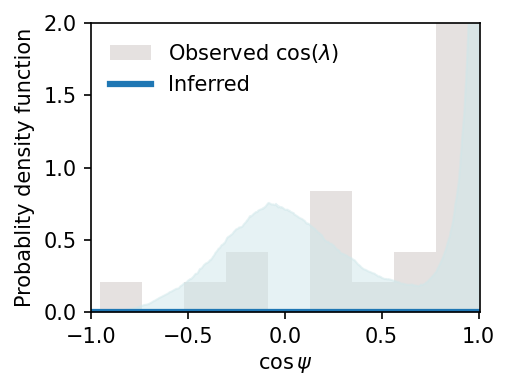

In [16]:
plt.figure(figsize=(3.5,2.7),dpi=150)

plt.hist(np.cos(obs_lam), color='#e5e1e0', bins=9, zorder=0,
         density=True, label='Observed $\cos(\lambda)$', alpha=1)

q025, q16, q50, q84, q975 = np.percentile(draws, [2.5, 16, 50, 84, 97.5], axis=1)/2
plt.plot(2*x-1, q50, color='C0', label='Inferred', linewidth=3)
plt.fill_between(2*x-1, q16, q84, alpha=0.5, color='#7dabd0')
plt.fill_between(2*x-1, q025, q975, alpha=0.5, color='#cfe7ea')

plt.ylim([0,2])
plt.xlim([-1,1.01])

plt.xlabel(r'$\cos{\psi}$')
plt.ylabel('Probablity density function')

plt.legend(framealpha=0)

plt.tight_layout()
# plt.savefig(f'./plots/psi_inferred_subSat{ncomps}comp.png')